### This is the accompanying notebook for the blog (https://emer2gent.org/2020/04/06/the-impact-and-importance-of-testing-data-a-known-unknown/) based on data collected by 6 April

This is an initial step to ensure toggle key is enabled on all cells

In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

Reading libraries

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import optimize

import pandas as pd
import datetime as dt

import seaborn as sns

hide_toggle()

Read from URL and convert to long for confirmed cases. This is currently not set-up to read from the storage. Plan in next update of notebook

In [5]:
url_confirmed="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url_fatalities = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
url_recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

raw_data_confimed=pd.read_csv(url_confirmed)
raw_data_fatalities = pd.read_csv(url_fatalities)
raw_data_recovered = pd.read_csv(url_recovered)

hide_toggle()

This is a conversion from wide to long. The datasets are timeseries datasets, with dates in column names, which isn't the most convenient format. 

In [6]:
val_cols = list(raw_data_confimed.columns)

raw_data_confimed_long = pd.melt(raw_data_confimed, id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
        value_vars=val_cols[4:], value_name="ConfirmedCases", var_name="Date")
raw_data_fatalities_long = pd.melt(raw_data_fatalities, id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
        value_vars=val_cols[4:], value_name="Fatalities", var_name="Date")
raw_data_recovered_long = pd.melt(raw_data_recovered, id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
        value_vars=val_cols[4:], value_name="Recovered", var_name="Date")

hide_toggle()

Some columns being renamed with change of special characters to work with the previous versions of code 

In [7]:
raw_data_confimed_long.columns = raw_data_confimed_long.columns.str.replace("/", "_")
raw_data_fatalities_long.columns = raw_data_fatalities_long.columns.str.replace("/", "_")
raw_data_recovered_long.columns = raw_data_recovered_long.columns.str.replace("/", "_")

hide_toggle()

Initial data read-in. This is currently using API (https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)

In [8]:
initial_import_confirmed = pd.DataFrame(raw_data_confimed_long.drop(columns=['Lat','Long']))
initial_import_fatalities = pd.DataFrame(raw_data_fatalities_long.drop(columns=['Lat','Long']))
initial_import_recovered = pd.DataFrame(raw_data_recovered_long.drop(columns=['Lat','Long']))
#pd.read_csv('data/data_raw.csv')



hide_toggle()

Combining the recovered, fatalities and confirmed cases into a single data frame

In [9]:
initial_import_conf_fatality = pd.merge(initial_import_confirmed, initial_import_fatalities, on=['Province_State', 'Country_Region','Date'])
#initial_import_conf_fatality['Date']=pd.to_datetime(initial_import_conf_fatality['Date'])

initial_import = pd.merge(initial_import_conf_fatality, initial_import_recovered, on = ['Province_State', 'Country_Region','Date'])
initial_import['Date']=pd.to_datetime(initial_import['Date'])

hide_toggle()

First Cut Processing, calculating the total cases for a country and extracting a minimum date to calculate days from onset

In [10]:
subset = initial_import[initial_import.ConfirmedCases !=0]

min_date = pd.DataFrame(subset.groupby(['Country_Region'])['Date'].min())

total_cases = pd.DataFrame(subset.groupby(['Country_Region','Date'])['ConfirmedCases'].sum())

total_fatality = pd.DataFrame(subset.groupby(['Country_Region','Date'])['Fatalities'].sum())

total_recoveries = pd.DataFrame(subset.groupby(['Country_Region','Date'])['Recovered'].sum())

total_cases.reset_index(inplace=True)
min_date.reset_index(inplace=True)
total_fatality.reset_index(inplace=True)

total_recoveries.reset_index(inplace=True)

hide_toggle()


Start calculating the day of onset. 

In [11]:
total_cases_minimum_date = pd.merge(total_cases, min_date, on = ['Country_Region'])
total_cases_minimum_date.rename(columns = {'Date_y':'onset_date', 'Date_x':'Date'}, inplace=True)

train_subset_minimum_date = pd.merge(total_cases_minimum_date, total_fatality, on = ['Country_Region', 'Date'])

train_subset_minimum_date = pd.merge(train_subset_minimum_date, total_recoveries, on =['Country_Region','Date'])
train_subset_minimum_date['days_from_onset']= (pd.to_datetime(train_subset_minimum_date['Date'])-
                                               pd.to_datetime(train_subset_minimum_date['onset_date'])).dt.days

hide_toggle()

READ testing data and see how it compares to results information, maybe normalize to total testing

In [22]:
total_tests = pd.read_csv("/data/sun/ourworldindata_covid-testing/full-list-total-tests-for-covid-19.csv")
total_tests['Date']=pd.to_datetime(total_tests['Date'])

In [23]:
total_tests.head()

,Entity,Code,Date,Cumulative total tests
0,France - units unclear,NaN,2020-02-24,31
1,France - units unclear,NaN,2020-02-25,146
2,France - units unclear,NaN,2020-02-26,412
3,France - units unclear,NaN,2020-02-27,851
4,France - units unclear,NaN,2020-02-28,1316


In [24]:
entity_name_dictionary = {'France - units unclear' : 'France', 
                          'Germany - samples tested' : 'Germany',
                          'India - people tested' : 'India_p', 
                          'India - samples tested' : 'India',
                          'Italy - units unclear' : 'Italy', 
                          'South Korea - cases tested' : 'Koreas, South',
                          'United Kingdom - people tested' : 'United Kingdom',
                          'United States - inconsistent units (COVID Tracking Project)' : 'US_p',
                          'United States - specimens tested (CDC)' : 'US'}

In [27]:
total_tests['Country_Region'] = total_tests['Entity'].map(entity_name_dictionary)

In [28]:
total_tests.head()

,Entity,Code,Date,Cumulative total tests,Country_Region
0,France - units unclear,NaN,2020-02-24,31,France
1,France - units unclear,NaN,2020-02-25,146,France
2,France - units unclear,NaN,2020-02-26,412,France
3,France - units unclear,NaN,2020-02-27,851,France
4,France - units unclear,NaN,2020-02-28,1316,France


In [53]:
test_data_merged = pd.merge(total_tests, train_subset_minimum_date, on=['Country_Region','Date'], how='inner' )

In [56]:
test_data_merged['case_to_test_ratio']=test_data_merged['ConfirmedCases']/test_data_merged['Cumulative total tests']

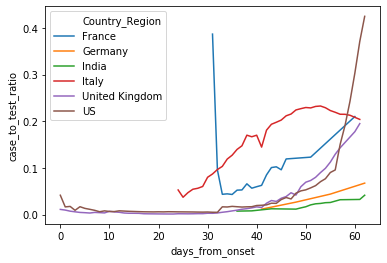

In [59]:
sns.lineplot(data= test_data_merged, x='days_from_onset', y='case_to_test_ratio', hue='Country_Region')

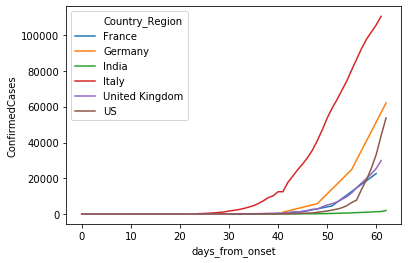

In [87]:
sns.lineplot(data= test_data_merged, x='days_from_onset', y='ConfirmedCases', hue='Country_Region')

In [66]:
len(test_data_merged['Country_Region'].unique())

6

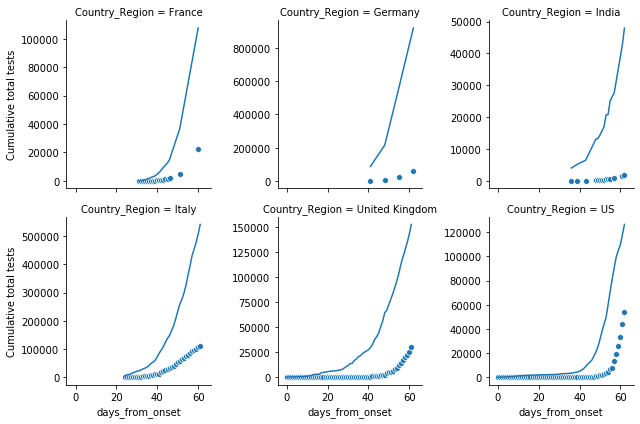

In [86]:
g = sns.FacetGrid(data=test_data_merged, col='Country_Region', col_wrap=3, sharey=False)
g.map(sns.scatterplot, 'days_from_onset', 'ConfirmedCases')#.set_titles("{col_name}"))
g.map(sns.lineplot, 'days_from_onset', 'Cumulative total tests')